# AlexNet

AlexNet은 Alex Khrizevsky의 이름은 딴것으로 2012년에 개최한 ImageNet Large Scale Visual Recognition Challenge(ILSVRC) 대회에서 우승을 차지한 딥러닝 기반 이미지 분류기(image classifier, image classification)이다. ILSVRC는 이미지 인식(image recognition) 경진대회로 2010년부터 참가자들에게 대용량의 이미지 데이터셋을 주고 이미지 분류 알고리즘의 성능을 평가하는 대회이다. ImageNet 데이터셋은 14,197,122개의 이미지로 분류분야에서 1,000의 클래스, 객체 탐지 분야에서 1,034,908개의 바운딩 박스(bounding box), WordNet의 21,841개의 레이블들이 존재한다. 

AlexNet이 지닌 가장 큰 기여는 딥러닝은 이론만 장황하고 성능은 형편없는 기술로 여겨졌는데, 당시 성능이 제일 좋았던 것은 특징 추출기로 HoG(histograms of oriented gradients)와 분류기로 SVM(support vector machines)을 결합한 전통적인 방법론보다 컴퓨터 비전 분야에서 딥러닝이 최고의 성능을 낼 수 있다고 증명했다. AlexNet은 1998년에 개발된 LeNet과 비슷하지만, 거의 15년이 지난 지금 성능이 향상된 이유는 하드웨어 성능 상승과 GPU 병렬처리에 있다. AlexNet 등장으로 딥러닝 용어가 확산되고 머신러닝의 기술적 문제들 대부분 해결한 제프리 힌튼(Geoffrey E. Hinton) 연구팀이다.

<div>
    <img src="https://unerue.synology.me/course/computer-vision/alexnet1.png" style="height: 360px;" />
</div>

### ReLU 활성화 함수

ReLU(rectfied linear unit)는 딥러닝 모형을 경사하강법(gradient descent)으로 학습할 때 빠르게 수렴하고 일반화(generalization)과 기울기 소실(gradient vanishing) 문제를 피할 가능성이 높다. 시그모이드(sigmoid)나 하이퍼볼릭 탄젠트(hyperbolic tahgent, tanh)을 미분하면 범위가 $[0, 1/4]$ 더 미분하면 할 수록 계속 0에 가까워지는 문제가 있다. 아래의 그림은 네 개의 층으로 이루어진 CNN에 CIFAR(Canadian institute for advanced research)-10 데이터셋을 학습시켰을 때 saturating nonlinearity(sigmoid, tanh)보다 non-saturatung nonlinearity(ReLU)의 학습 속도가 6배 빠르다.

<div>
    <img src="https://unerue.synology.me/course/computer-vision/alexnet2.png" style="height: 480px;" />
</div>

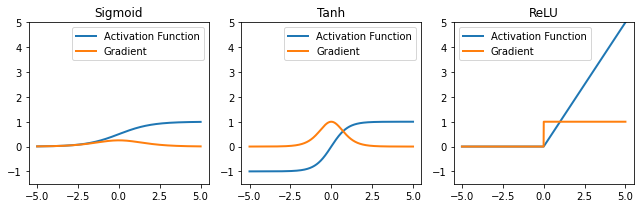

In [6]:
from typing import Callable
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim
import torch.nn.functional as F


class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {'name': self.name}


class Sigmoid(ActivationFunction):
    def forward(self, x: Tensor) -> Tensor:
        return 1 / (1 + torch.exp(-x))
    

class Tanh(ActivationFunction):
    def forward(self, x: Tensor) -> Tensor:
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)


class ReLU(ActivationFunction):  
    def forward(self, x: Tensor) -> Tensor:
        return x * (x > 0).float()

    
act_fn_by_name = {
    'sigmoid': Sigmoid,
    'tanh': Tanh,
    'relu': ReLU,
}


def get_grads(act_fn: nn.Module, x: Tensor) -> Tensor:
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    return x.grad


def vis_act_fn(act_fn: Callable, ax: List, x: Tensor) -> None:
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    
    ax.plot(x, y, linewidth=2, label='Activation Function')
    ax.plot(x, y_grads, linewidth=2, label='Gradient')
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())


act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, axes.flat[i], x)

fig.subplots_adjust(hspace=0.3)
fig.tight_layout()
plt.show()

### Multiple GPUs

AlexNet은 ImageNet 데이터셋을 두 개의 GPU로 학습하며 이를 GPU 병렬화(parallelization)라고 한다. 연구팀은 개발한 모형에 120만개의 이미지 데이터를 학습하기 위해서는 한 대의 GPU로는 매우 부족하다고 판단했다. 그래서 해당 연구에서는 두 개의 GPU로 모형을 나눠서 학습할 수 있게 병렬화처리하였고 몇 군데의 계층에서 연결(connection)하였다. 이렇게 학습된 AlexNet은 top-1 erroe와 top-5 error가 1.7%, 1.2% 감소되었으며 학습속도도 매우 빨라졌다. 예를 들어, 90개의 커널(kernel)이 있다고 하면 45개를 첫 번째 GPU에 할당하고 남는 45개를 두 번째 GPU에 할당하여 학습한다. 

자세히 설명하면 AlexNet은 데이터를 두 개의 GPU로 나누어 학습하다가 세 번째 CNN 계층에서 GPU를 통합시켰다. 이를 통해 계산량의 허용가능한 부분까지 통신량을 정확하게 조정할 수 있었다.
 
<div>
    <img src="https://unerue.synology.me/course/computer-vision/alexnet3.png" style="height: 360px;" />
</div>
 
위 그림은 첫 번째와 두 번째 GPU에서 각각에서 학습된 특징맵이다. 첫 번째 GPU에서는 색상과 관련 없는 정보를 학습하고 두 번째 GPU는 색상과 관련된 정보를 학습하는 것을 확인할 수 있다. 이처럼 AlexNet은 각각의 GPU는 독립적으로 학습한다.

### Local Response Normalization

LRN(local response normalization)은 차후 알게될 배치 정규화(batch normalization)로 인해 지금은 잘 사용하지 않는 정규화 기법이다. CNN의 커널이 이미지르 스캔할 때 특정 픽셀값이 다른 픽셀에 비해 지나치게 높은 값ㅇ르 가지고 있어 주변에 큰 영향력을 끼치는 것을 억제시키는 일반화 방법 중 하나이다. 이는 tahn이나 sigmoid처럼 최대값이 존재하는 것이 아닌 ReLU와 같은 활성화 함수를 지나칠 때 큰 값이 통과되는 문제의 부작용을 줄이기 위해 사용했다. 

LRN은 일반화(generalizaion) 성능을 높이기 위한 목적으로 사용한다. 시그모이드나 하이퍼볼릭 탄젠트 활성화 함수는 입력 데이터의 속성에 따라 편차가 심하면 saturating되는 현상이 심해져 기울기 소실(gradient vanishing)을 유발할 수 있다. 반면에 ReLU는 non-saturating nonlinearity 함수이기 때문에 saturating을 예방하기 위한 입력 데이터의 정규화가 필요없다. 하지만 ReLU는 양수값을 받으면 그 값을 그대로 뉴런에 전달하기 때문에 너무 큰 값이 전달되어 주변의 낮은 값이 뉴런에 전달되는 것을 막을 수 있다. 이를 예방하기 위한 정규화 방법이 LRN이다.

$$b_{x,y}^{i}=a_{x,y}^{i}/\bigg(k+\alpha \sum_{j=\max{0,i-n/2}}^{\min{N-1,i+n/2}}(a_{x,y}^{i})^{2}\bigg)^\beta$$

논문에서는 LRN을 측면 억제(later inhibition)의 형태로 구현된다고 나와 있다. 측면 억제란 강한 자극이 주변의 약한 자극을 전달하는 것을 막는 효과를 뜻한다.

<div>
    <img src="https://unerue.synology.me/course/computer-vision/alexnet5.png" style="height: 360px;" />
</div>

위 그림은 측면 억제의 유명한 그림인 헤르만 격자(Herrman grid)이다. 검은 사각형안에 흰색의 선이 지나가고 있는데 신기한 것은 흰색의 선에 집중하지 않을 때 회색 점이 보인다. 이러한 현상이 측면 억제에 의해 발생하는 것이다. 이는 흰색으로 둘러싸인 측면에서 억제를 발생시키기 때문에 흰색이 더 반감되어 보이는 현상이다.

### Overlapping Pooling

LeNet에서 사용했던 평균 풀링과 다르게 AlexNet에서느 맥스 풀링(max pooling)을 사용하였다. 맥스 풀링은 가로세로 방향의 공간을 줄이는 연산이다. 최대 풀링은 윈도우 크기에 비례하여 스트라이드로 연산하고 해당 값을 최대값을 받는다. 풀링 계층은 학습해야할 매개변수가 없으며, 채널의 수가 변하지 않는다. 또한, 입력의 변화에 영향을 적게 받는다. 이는 이동과 왜곡 불변성(shift and distortion invariance)이 높아진다. 즉, 강건하다. 여기서 AlexNet은 풀링을 겹치는 방식으로 사용하였다. 

<div>
    <img src="https://unerue.synology.me/course/computer-vision/alexnet4.png" style="height: 380px;" />
</div>

In [1]:
import numpy as np


class MaxPooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = img2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

### Data augmentation

데이터 증강(data augmentation)은 학습할 데이터를 좀 더 다양한 특징을 부여하여 모형이 이를 학습할 수 있도록 만들어진 개념이다. 이러한 기법은 적은 노력으로 다양한 데이터를 형성해 과적합을 피할 수 있고 연산량이 적고 학습된 결과가 매우 뛰어나다. AlexNet에서는 랜덤 크롭과 색상을 변경하는 기법을 사용했다. 랜덤 크롭은 256x256 이미지에서 224x224 크기로 크롭하고 크롭의 위치는 중앙, 좌측 상단, 좌측 하단, 우측 상단, 우측 하단 이렇게 5개의 위치에서 크롭한다. RGB 채널의 강도를 변경하는 기법은 PCA(principle compoenet analysis)를 이용해 RGB 색상에 대한 eigenvalue를 찾아 가우시안 분포에서 추출한 랜덤 변수를 곱해서 RGB 값에 더해준다. 이는 조명의 영향과 색의 intensity 변화에 대한 불변성을 가진다고 하고 이 기법을 통해 top-1 error를 1% 낮추었다.

### 드롭아웃

과거 과적합(overfitting)을 억제하기 위해 사용한 방법으로 가중치 감소(weight dacay)가 있다. 학습 과정에서 큰 가중치에 큰 패널티를 부과해서 과적합을 막는 방법이다. 하지만 이 방법은 지나치게 학습을 억제시킬 수 있고 신경망이 복잡해지면서 가중치 감소만으로 대응하기 힘들어졌다. 드롭아웃은 각 뉴런끼리 의존성을 줄이기 위해 개발되었다. 드롭아웃된 뉴런(neuron)은 순전파와 역전파에 영향을 주지 않고 매 입력마다 드랍아웃을 적용시키면 가중치는 공유되지만 신경망은 서로 다른 구조를 띄게 된다. 뉴런은 특정 다른 뉴런의 존재에 의존하지 않기 때문에 이 기법은 복잡한 뉴런의 상호적응(co-adaptation)를 감소시킨다. 상호적응은 어떤 뉴런이 다른 특정 뉴런에 의존적으로 변하는 것이다. 그러므로 서로 다른 뉴런의 임의의 부분 집합끼리 결합에 유용한 강겅한(robust) 특징을 학습할 수 있다. 상호적응 문제는 신경망의 학습 중 어느 시점에서 같은 층의 두 개 이상의 노드의 입력 및 출력 연결강도가 같아지면, 아무리 학습이 진행되어도 그 노드들은 같은 일을 수행하게 되어 불필요한 중복이 생기는 문제를 말한다. 즉 연결강도들이 학습을 통해 업데이트 되더라도 이들은 계속해서 서로 같은 입출력 연결 강도들을 유지하게 되고 이는 결국 하나의 노드로 작동하는 것으로써, 이후 어떠한 학습을 통해서도 이들은 다른 값으로 나눠질 수 없고 상호 적응하는 노드들에는 낭비가 발생하는 것이다. 결국 이것은 컴퓨팅 파워와 메모리의 낭비로 이어진다. 드랍아웃은 이러한 상호적응 문제를 해소한다. 즉, 드랍아웃이 임의로 노드들을 생략할 때 이러한 상호 적응 중인 노드들 중 일부는 생략하고 일부는 생략하지 않게 되므로 학습 중 상호 적응이 발생한 노드들이 분리될 수 있어서 상호 적응 문제를 회피할 수 있게 된다.

기존 ImageNet 대회에서 모형의 성능을 높이기 위해 앙상블 기법을 사용하였다. 앙상블 기법은 테스트 에러(test error)를 감소시키기 위해 효과적인 방법이지만 여러 모형을 학습하고 추론하는 과정이 비효율적이라 판단한 연구팀은 AlexNet에 드롭아웃을 적용하였다. 또한 AlexNet은 두 개의 FC 레이어에만 드롭아웃을 적용했다.

### 파이토치를 이용한 AlexNet 구현

In [28]:
from typing import Any

import torch
import torch.nn as nn
from torchinfo import summary


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

    
model = AlexNet()
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  --                        --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 96, 55, 55]           34,944
│    └─ReLU: 2-2                         [1, 96, 55, 55]           --
│    └─LocalResponseNorm: 2-3            [1, 96, 55, 55]           --
│    └─MaxPool2d: 2-4                    [1, 96, 27, 27]           --
│    └─Conv2d: 2-5                       [1, 256, 27, 27]          614,656
│    └─ReLU: 2-6                         [1, 256, 27, 27]          --
│    └─LocalResponseNorm: 2-7            [1, 256, 27, 27]          --
│    └─MaxPool2d: 2-8                    [1, 256, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-10                        [1, 384, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 384, 13, 13]          1,32

#### AdaptiveAvgPool2d

여러 입력 평면으로 구성된 입력 신호에 2D 적응형 평균 풀링을 적용합니다. 출력은 모든 입력 크기에 대해 H x W 크기입니다. 출력 기능의 수는 입력 평면의 수와 같습니다.

output_size – H x W 형식의 이미지 대상 출력 크기입니다. 정사각형 이미지 H x H의 경우 튜플(H, W) 또는 단일 H가 될 수 있습니다. H 및 W는 int 또는 None이 될 수 있음을 의미합니다. 크기는 입력의 크기와 동일하다.

In [5]:
# import jax
# import flax.linen as nn


# class AlexNet(nn.Module):
#     def setup(self):
#         nn.Sequential(
#             nn.Conv(),
#             nn.relu(),            
#         )